In [0]:
import pandas as pd
import re
import numpy as np

from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from datetime import datetime
from dateutil.parser import parse

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as snsimport pandas as pd

from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType
from pyspark.sql.types import StringType
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import *
from pyspark.sql.functions import lit
from pyspark.sql import DataFrameStatFunctions as statFunc

#I. Data Processing & Cleaning

In [0]:
customer = pd.read_csv('train.csv')
customer.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [0]:
customer.loc[419580, 'device'] = customer.loc[419580, 'device'].replace('subjectAgent: NoticiasBoom', 'subjectAgent(NoticiasBoom)')

In [0]:
# # Check for exception
# for i in range(len(customer)):
#     for col in sub_col:
#         sample = customer.loc[i, col]
#         if 'adwordsClickInfo' in sample:
#             others = sample.split('adwordsClickInfo')[0]
#             key_list = re.findall(r'"([.a-zA-Z]+)":', others)
#             value_list = re.findall(r': "(.+?)"', others)
#             adwordsClickInfo = sample.split('adwordsClickInfo')[1]
#             key_list.append('adwordsClickInfo')
#             value_list.append(re.findall(r'{.*}', adwordsClickInfo)[0])
#         else:
#             key_list = re.findall(r'"([.a-zA-Z]+)":', sample)
#             value_list = re.findall(r':[ "]*([a-zA-Z0-9 ]*)["]*', sample)
#         if len(key_list) != len(value_list):
#             print (col, i)

In [0]:
def create_dict(element):
    if 'adwordsClickInfo' in element:
        others = element.split('adwordsClickInfo')[0]
        key_list = re.findall(r'"([.a-zA-Z]+)":', others)
        value_list = re.findall(r': "(.+?)"', others)
        adwordsClickInfo = element.split('adwordsClickInfo')[1]
        key_list.append('adwordsClickInfo')
        value_list.append(re.findall(r'{.*}', adwordsClickInfo)[0])
    else:
        key_list = re.findall(r'"([.a-zA-Z]+)":', element)
        value_list = re.findall(r':[ "]*([a-zA-Z0-9 ]*)["]*', element)
    element_dict = {}
    for i in range(len(key_list)):
        element_dict[key_list[i]] = value_list[i]
    return element_dict

In [0]:
sub_col = ['device', 'geoNetwork', 'totals', 'trafficSource']
for col in sub_col:
    customer[col] = customer[col].apply(create_dict)

In [0]:
def find_key(col):
    key_list = []
    for i in range(len(customer)):
        sample = customer.loc[i, col]
        key = list(sample.keys())
        if i != 0:
            key_list += key
    return list(set(key_list))

In [0]:
col_type = {}
for col in sub_col:
    col_type[col] = find_key(col)

In [0]:
for key in col_type.keys():
    for col in col_type[key]:
        customer[col] = customer[key].apply(lambda x: x[col] if col in x.keys() else np.nan)

In [0]:
transactionRevenue = customer[customer['transactionRevenue'].isna() == False]
transactionRevenue.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,...,bounces,transactionRevenue,pageviews,medium,adwordsClickInfo,source,keyword,referralPath,adContent,campaign
752,Direct,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",6194193421514403509,"{'continent': 'Americas', 'subContinent': 'Nor...",6194193421514403509_1472843572,Not Socially Engaged,"{'visits': '1', 'hits': '11', 'pageviews': '11...","{'campaign': '(not set)', 'source': '(direct)'...",1472843572,...,NaN,37860000,11,(none),"{""criteriaParameters"": ""not available in demo ...",(direct),NaN,NaN,NaN,(not set)
753,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",5327166854580374902,"{'continent': 'Americas', 'subContinent': 'Nor...",5327166854580374902_1472844906,Not Socially Engaged,"{'visits': '1', 'hits': '11', 'pageviews': '10...","{'campaign': '(not set)', 'source': 'google', ...",1472844906,...,NaN,306670000,10,organic,"{""criteriaParameters"": ""not available in demo ...",google,(not provided),NaN,NaN,(not set)
799,Referral,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",8885051388942907862,"{'continent': 'Americas', 'subContinent': 'Nor...",8885051388942907862_1472827393,Not Socially Engaged,"{'visits': '1', 'hits': '13', 'pageviews': '11...","{'referralPath': '/', 'campaign': '(not set)',...",1472827393,...,NaN,68030000,11,referral,"{""criteriaParameters"": ""not available in demo ...",mall.googleplex.com,NaN,/,NaN,(not set)
802,Referral,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",0185467632009737931,"{'continent': 'Americas', 'subContinent': 'Nor...",0185467632009737931_1472846398,Not Socially Engaged,"{'visits': '1', 'hits': '13', 'pageviews': '12...","{'referralPath': '/', 'campaign': '(not set)',...",1472846398,...,NaN,26250000,12,referral,"{""criteriaParameters"": ""not available in demo ...",mall.googleplex.com,NaN,/,NaN,(not set)
859,Referral,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",3244885836845029978,"{'continent': 'Americas', 'subContinent': 'Nor...",3244885836845029978_1472824817,Not Socially Engaged,"{'visits': '1', 'hits': '17', 'pageviews': '14...","{'referralPath': '/', 'campaign': '(not set)',...",1472824817,...,NaN,574150000,14,referral,"{""criteriaParameters"": ""not available in demo ...",mall.googleplex.com,NaN,/,NaN,(not set)


In [0]:
customer.to_csv('customer_dataset.csv', index=False)

In [0]:
# transform the visitStartTime into datetime format
customer['visitStartTime'] = pd.to_datetime(customer['visitStartTime'], unit='s')
# retrieve the visit_month as a variable
customer['visit_month'] = customer['visitStartTime'].dt.month

In [0]:
## remove aggregated or meaningless columns
customer = customer.drop(['device', 'geoNetwork','sessionId','totals','trafficSource',
                          'visitId','visitStartTime','mobileDeviceInfo','longitude','latitude','cityId',
                          'adwordsClickInfo'], axis = 1)
customer = customer.drop(['socialEngagementType', 'deviceCategory', 'screenColors', 'mobileDeviceModel', 
                         'mobileDeviceBranding', 'operatingSystemVersion', 'mobileDeviceMarketingName', 
                         'language', 'mobileInputSelector', 'flashVersion', 'browserVersion', 'browserSize',
                         'screenResolution', 'networkLocation', 'visits', 'referralPath'], axis = 1)
customer.head()

,channelGrouping,date,fullVisitorId,visitNumber,isMobile,operatingSystem,browser,continent,region,subContinent,...,pageviews,newVisits,hits,bounces,campaign,source,medium,adContent,keyword,visit_month
0,Organic Search,20160902,1131660440785968503,1,false,Windows,Chrome,Asia,Izmir,Western Asia,...,1,1,1,1,(not set),google,organic,NaN,(not provided),9
1,Organic Search,20160902,377306020877927890,1,false,Macintosh,Firefox,Oceania,not available in demo dataset,Australasia,...,1,1,1,1,(not set),google,organic,NaN,(not provided),9
2,Organic Search,20160902,3895546263509774583,1,false,Windows,Chrome,Europe,Community of Madrid,Southern Europe,...,1,1,1,1,(not set),google,organic,NaN,(not provided),9
3,Organic Search,20160902,4763447161404445595,1,false,Linux,UC Browser,Asia,not available in demo dataset,Southeast Asia,...,1,1,1,1,(not set),google,organic,NaN,google + online,9
4,Organic Search,20160902,27294437909732085,2,true,Android,Chrome,Europe,not available in demo dataset,Northern Europe,...,1,NaN,1,1,(not set),google,organic,NaN,(not provided),9


In [0]:
## convert 'fullVisitorId' to string
customer['fullVisitorId'] = [str(x) for x in customer['fullVisitorId']]

In [0]:
## convert 'date' from string to date format
customer['date'] = [parse(str(x)) for x in customer['date']]

In [0]:
## convert 'transactionRevenue' to float format
customer['transactionRevenue'] = customer['transactionRevenue'].astype(float)

In [0]:
customer.head()

,channelGrouping,date,fullVisitorId,visitNumber,isMobile,operatingSystem,browser,continent,region,subContinent,...,pageviews,newVisits,hits,bounces,campaign,source,medium,adContent,keyword,visit_month
0,Organic Search,2016-09-02,1131660440785968503,1,false,Windows,Chrome,Asia,Izmir,Western Asia,...,1,1,1,1,(not set),google,organic,NaN,(not provided),9
1,Organic Search,2016-09-02,377306020877927890,1,false,Macintosh,Firefox,Oceania,not available in demo dataset,Australasia,...,1,1,1,1,(not set),google,organic,NaN,(not provided),9
2,Organic Search,2016-09-02,3895546263509774583,1,false,Windows,Chrome,Europe,Community of Madrid,Southern Europe,...,1,1,1,1,(not set),google,organic,NaN,(not provided),9
3,Organic Search,2016-09-02,4763447161404445595,1,false,Linux,UC Browser,Asia,not available in demo dataset,Southeast Asia,...,1,1,1,1,(not set),google,organic,NaN,google + online,9
4,Organic Search,2016-09-02,27294437909732085,2,true,Android,Chrome,Europe,not available in demo dataset,Northern Europe,...,1,NaN,1,1,(not set),google,organic,NaN,(not provided),9


In [0]:
## Remove 'not available in demo dataset' in the 'city' columns
customer['city']=np.where(customer['city'] == 'not available in demo dataset', None, customer['city'])

In [0]:
# count of each value in each variable
for i in customer.columns:
    print(i)
    print(customer[i].value_counts())
    print('\n')

channelGrouping
Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64


date
2016-11-28    4807
2016-11-15    4685
2016-11-14    4466
2016-11-30    4435
2016-10-26    4375
              ... 
2017-05-14    1290
2017-05-13    1251
2016-12-30    1232
2016-12-24    1231
2016-12-31    1211
Name: date, Length: 366, dtype: int64


fullVisitorId
1957458976293878100    278
824839726118485274     205
3608475193341679870    201
1856749147915772585    199
3269834865385146569    155
                      ... 
4387111074989349846      1
6925841960889320563      1
7605830260055163928      1
2161103245286901842      1
3048871425949757419      1
Name: fullVisitorId, Length: 716924, dtype: int64


visitNumber
1      703060
2       92548
3       35843
4       19157
5       11615
        ...  
306         1
349         1
350  

# II. Exploratory Data Analysis

In [0]:
from datetime import datetime
from dateutil.parser import parse

## 2.1 80/20 rule

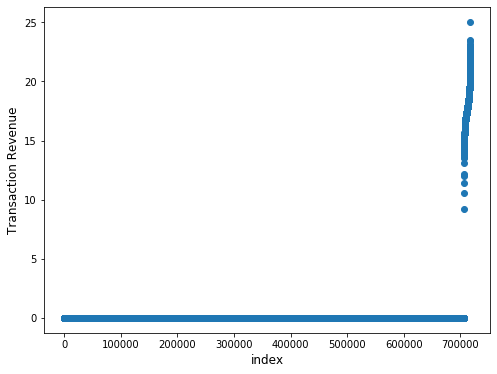

In [0]:
id_trans = customer.groupby('fullVisitorId')['transactionRevenue'].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(id_trans.shape[0]), np.sort(np.log1p(id_trans['transactionRevenue'].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('Transaction Revenue', fontsize=12)
plt.show()

### ***Data Finding: The 80/20 rule has proven true for many businesses – only a small percentage of customers produce most of the revenue.*** 

In [0]:
customer_with_revenue = (customer['transactionRevenue']>0).sum()
print('Number of unique customers that contributed revenue :', customer_with_revenue)
print('Number of unique customers that contributed revenue/total number of unique customers :',
      round(100*customer_with_revenue/id_trans.shape[0], 2), "%")

Number of unique customers that contributed revenue : 11515
Number of unique customers that contributed revenue/total number of unique customers : 1.61 %


## 2.2 Time Series

In [0]:
date_trans = customer.groupby('date')['transactionRevenue'].sum().reset_index()

In [0]:
date_visitor = customer.groupby('date')['fullVisitorId'].nunique().reset_index()

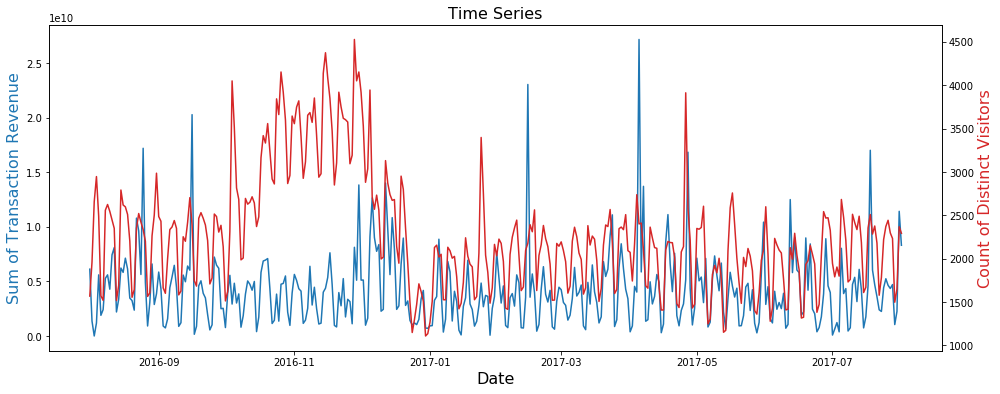

In [0]:
fig, ax1 = plt.subplots(figsize=(16,6))
color = 'tab:blue'
ax1.set_title('Time Series', fontsize=16)
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Sum of Transaction Revenue', fontsize=16, color=color)
ax2 = plt.plot(date_trans['date'], date_trans['transactionRevenue'])
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Count of Distinct Visitors', fontsize=16, color=color)
ax2 = plt.plot(date_visitor['date'], date_visitor['fullVisitorId'], color=color)
plt.show()

### ***Data Finding: From 2016-10 to 2016-12, there was a period of significant increase in distinct number of visitors but not for the sum of transaction revenue. This could be possibly caused by an unsuccessful marketing compaign that brought in lots of visitors but low conversion rates or there was a surge of spam clicks/visitors.***

# III. Modeling

## 3.1 Feature Selection

In [0]:
from datetime import datetime as dt

In [0]:
model_data = transactionRevenue

In [0]:
## remove aggregated or meaningless columns
drop_vars = ['device', 'geoNetwork','sessionId','totals','trafficSource',
                          'visitId','mobileDeviceInfo','longitude','latitude','cityId',
                          'adwordsClickInfo','socialEngagementType', 'deviceCategory', 'screenColors', 'mobileDeviceModel', 
                         'mobileDeviceBranding', 'operatingSystemVersion', 'mobileDeviceMarketingName', 
                         'language', 'mobileInputSelector', 'flashVersion', 'browserVersion', 'browserSize',
                         'screenResolution', 'networkLocation', 'visits', 'referralPath','date']
model_data = model_data.drop(columns=drop_vars)

In [0]:
pd.set_option('display.max_columns', 500)

In [0]:
pd.set_option('display.max_rows', 25000)

In [0]:
model_data.head()

,channelGrouping,fullVisitorId,visitNumber,visitStartTime,isMobile,browser,operatingSystem,continent,city,networkDomain,country,region,subContinent,metro,bounces,newVisits,pageviews,transactionRevenue,hits,keyword,adContent,medium,source,campaign
752,Direct,6194193421514403509,1,1472843572,false,Chrome,Linux,Americas,Ann Arbor,,United States,Michigan,Northern America,Detroit MI,NaN,1,11,37860000,11,NaN,NaN,(none),(direct),(not set)
753,Organic Search,5327166854580374902,3,1472844906,false,Chrome,Macintosh,Americas,New York,,United States,New York,Northern America,New York NY,NaN,NaN,10,306670000,11,(not provided),NaN,organic,google,(not set)
799,Referral,8885051388942907862,7,1472827393,false,Chrome,Linux,Americas,New York,,United States,New York,Northern America,New York NY,NaN,NaN,11,68030000,13,NaN,NaN,referral,mall.googleplex.com,(not set)
802,Referral,0185467632009737931,6,1472846398,false,Chrome,Windows,Americas,Mountain View,,United States,California,Northern America,San Francisco,NaN,NaN,12,26250000,13,NaN,NaN,referral,mall.googleplex.com,(not set)
859,Referral,3244885836845029978,4,1472824817,false,Chrome,Macintosh,Americas,not available in demo dataset,,United States,not available in demo dataset,Northern America,not available in demo dataset,NaN,NaN,14,574150000,17,NaN,NaN,referral,mall.googleplex.com,(not set)


In [0]:
# transform the visitStartTime into datetime format
model_data['visitStartTime'] = pd.to_datetime(model_data['visitStartTime'], unit='s')
# retrieve the visit_month as a variable
model_data['visit_month'] = model_data['visitStartTime'].dt.month

In [0]:
model_data['visit_month'].value_counts()

12    1409
8     1173
5     1118
7     1024
6      947
4      921
11     905
3      885
10     874
9      856
2      713
1      690
Name: visit_month, dtype: int64

In [0]:
model_data = model_data.drop(columns=['visitStartTime','fullVisitorId','keyword','adContent', 'campaign',
                                      'subContinent','region','metro'])

In [0]:
# model_data = model_data.drop(columns=['metro'])

In [0]:
## check the variables' data types and number of NAs
# model_data.info()

In [0]:
# transform the numerical variables into float data type, and impute the NAs
numerical_vars = ['pageviews','transactionRevenue','hits','newVisits','bounces']
for var in numerical_vars:
    model_data[var] = model_data[var].astype(float)
    model_data[var] = model_data[var].fillna(0)

In [0]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11515 entries, 752 to 903317
Data columns (total 17 columns):
channelGrouping       11515 non-null object
visitNumber           11515 non-null int64
isMobile              11515 non-null object
browser               11515 non-null object
operatingSystem       11515 non-null object
continent             11515 non-null object
city                  11515 non-null object
networkDomain         11515 non-null object
country               11515 non-null object
bounces               11515 non-null float64
newVisits             11515 non-null float64
pageviews             11515 non-null float64
transactionRevenue    11515 non-null float64
hits                  11515 non-null float64
medium                11515 non-null object
source                11515 non-null object
visit_month           11515 non-null int64
dtypes: float64(5), int64(2), object(10)
memory usage: 1.6+ MB


In [0]:
model_data['operatingSystem'] = np.where(model_data['operatingSystem'].isin(['Nintendo Wii','Firefox OS','Xbox','Nintendo WiiU',
                                                                            'FreeBSD','OpenBSD','Nokia','SunOS','NTT DoCoMo',
                                                                            'Nintendo 3DS','Samsung','BlackBerry']), 'Other', model_data['operatingSystem'])

In [0]:
model_data['browser'] = np.where(model_data['browser'].isin(['Coc Coc', 'Amazon Silk', 'Android Browser', 
                                                             'Mozilla Compatible Agent', 'MRCHROME', 'Maxthon', 
                                                             'BlackBerry', 'Nintendo Browser', 'Puffin', 'Nokia Browser', 
                                                             'Iron', 'LYF', 'SeaMonkey', 'Mozilla', 'Seznam', 'Apple', 
                                                             '', '0', 'Nichrome', 'osee2unifiedRelease', 'Lunascape', 
                                                             'DASH', 'ThumbSniper', 'no', 'YE', 'MQQBrowser', 'Android Runtime', 
                                                             'NokiaE52', 'Reddit', 'Konqueror', 'Changa 99695759', 'subjectAgent', 
                                                             'TCL P500M', 'User Agent', 'IE with Chrome Frame', 'M5', 'DoCoMo', 
                                                             'Hisense M20', 'CSM Click', 'HTC802t', 'ADM']), 'Other', model_data['browser'])
model_data['browser'] = np.where(model_data['browser']=='Safari ','Safari',model_data['browser'])

In [0]:
model_data['country'] = np.where(model_data['country'].isin(['Belarus', 'Kazakhstan', 'Finland', 'Dominican Republic', 'Bosnia ', 'Georgia', 'Jordan', 'Lithuania', 'Macedonia ', 'Kenya', 'Puerto Rico', 'Slovenia', 'Iraq', 'Latvia', 'Estonia', 'Uruguay', 'Guatemala', 'Azerbaijan', 'Costa Rica', 'Albania', 'Qatar', 'Cambodia', 'Kuwait', 'Panama', 'Cyprus', 'Kosovo', 'Lebanon', 'El Salvador', 'Ghana', 'C', 'Moldova', 'Bolivia', 'Oman', 'Armenia', 'Tanzania', 'Bahrain', 'Mongolia', 'Nepal', 'Myanmar ', 'Palestine', 'Honduras', 'Cameroon', 'Malta', 'Uganda', 'Trinidad ', 'Laos', 'Luxembourg', 'Jamaica', 'Senegal', 'R', 'Iceland', 'Ethiopia', 'Nicaragua', 'Kyrgyzstan', 'Paraguay', 'Macau', 'Montenegro', 'Congo ', 'Yemen', 'Uzbekistan', 'Sudan', 'Libya', 'Maldives', 'Mauritius', 'Mozambique', 'Brunei', 'Martinique', 'Zimbabwe', 'Angola', 'Afghanistan', 'Barbados', 'Madagascar', 'Rwanda', 'St', 'Fiji', 'Benin', 'Jersey', 'Iran', 'Guam', 'Zambia', 'Bahamas', 'Mauritania', 'Somalia', 'Bermuda', 'Burkina Faso', 'Haiti', 'Namibia', 'Mali', 'Guinea', 'Togo', 'Cura', 'Suriname', 'Aruba', 'Guadeloupe', 'Belize', 'Guyana', 'Gabon', 'Guernsey', 'New Caledonia', 'Grenada', 'U', 'Monaco', 'Chad', 'French Polynesia', 'French Guiana', 'Faroe Islands', 'Cape Verde', 'Andorra', 'Mayotte', 'Botswana', 'Swaziland', 'Turks ', 'Cayman Islands', 'Tajikistan', 'Malawi', 'Northern Mariana Islands', 'Burundi', 'Papua New Guinea', 'Djibouti', 'Niger', 'Gibraltar', 'Syria', 'Gambia', 'Bhutan', 'Sierra Leone', 'Liberia', 'Sint Maarten', 'Liechtenstein', 'Timor', 'Lesotho', 'Turkmenistan', 'Greenland', 'British Virgin Islands', 'Antigua ', 'Equatorial Guinea', 'Caribbean Netherlands', 'San Marino', 'Central African Republic', 'Isle of Man', 'Cook Islands', 'Dominica', 'Seychelles', 'Vanuatu', 'Marshall Islands', 'Comoros', 'Eritrea', 'American Samoa', 'Anguilla', 'Norfolk Island', 'Samoa', 'S']),
                                'Other', model_data['country'])

In [0]:
model_data['city'] = np.where(model_data['city'].isin(['Kirkland', 'Dallas', 'La Victoria', 'Kolkata', 'San Bruno', 'Bogota', 'Cambridge', 'Ankara', 'Amsterdam', 'Bucharest', 'Barcelona', 'San Diego', 'Izmir', 'Kiev', 'Berlin', 'Milan', 'Quezon City', 'Buenos Aires', 'Zurich', 'Stockholm', 'Pittsburgh', 'Dubai', 'Fremont', 'Boston', 'Irvine', 'Ahmedabad', 'Brisbane', 'Bien Hoa', 'Boardman', 'Hamburg', 'Ashburn', 'Osaka', 'Philadelphia', 'Athens', 'Tunis', 'Cupertino', 'Da Nang', 'Riyadh', 'Rio de Janeiro', 'Vienna', 'Milpitas', 'Prague', 'Shinjuku', 'Redmond', 'Gurgaon', 'Munich', 'Budapest', 'Rome', 'Columbus', 'Charlotte', 'Cebu City', 'Hai Phong', 'Vancouver', 'Boulder', 'Gothenburg', 'Santiago', 'Phoenix', 'Lisbon', 'Karachi', 'Jeddah', 'Eau Claire', 'Frankfurt', 'Denver', 'San Antonio', 'Sofia', 'Bursa', 'Bandung', 'Erode', 'Colombo', 'Krakow', 'Kitchener', 'Makati', 'Taguig', 'Oakland', 'San Mateo', 'Yokohama', 'Quebec City', 'Nakhon Pathom', 'Auckland', 'Thai Nguyen', 'Pozuelo de Alarcon', 'Redwood City', 'Mueang Khon Kaen District', 'Lagos', 'Indore', 'Lahore', 'Belo Horizonte', 'Jersey City', 'Manila', 'Zagreb', 'Portland', 'Surabaya', 'Orlando', 'Monterrey', 'Zhongli District', 'Marseille', 'Maracaibo', 'Antalya', 'Jaipur', 'Brussels', 'Laguna Beach', 'Saint Petersburg', 'Tbilisi', 'Calgary', 'Ningbo', 'Poznan', 'Adana', 'Nashville', 'Manchester', 'Mueang Chiang Mai District', 'Lake Oswego', 'Minneapolis', 'Brasilia', 'Lucknow', 'Lille', 'Piscataway Township', 'Belgrade', 'Burnaby', 'Buon Ma Thuot', 'Lyon', 'Miami', 'Montevideo', 'Shibuya', 'Petaling Jaya', 'Nairobi', 'Casablanca', 'Vung Tau', 'Bilbao', 'Hai Duong', 'Courbevoie', 'Medellin', 'Cork', 'Detroit', 'Santa Fe', 'Curitiba', 'Wroclaw', 'Evanston', 'Copenhagen', 'Kalamazoo', 'Oviedo', 'Tempe', 'Kampar', 'Chuo', 'Dalat', 'Perth', 'Chandigarh', 'Bordeaux', 'Kharagpur', 'Cluj', 'Mississauga', 'Nha Trang', 'Rotterdam', 'Kansas City', 'Malaga', 'Porto Alegre', 'Konya', 'Abu Dhabi', 'Council Bluffs', 'Oslo', 'Chico', 'Cairo', 'Baku', 'Subang Jaya', 'My Tho', 'Vinh', 'Skopje', 'South San Francisco', 'Can Tho', 'Am', 'Utrecht', 'Montreuil', 'Egham', 'Leeds', 'Ottawa', 'Goiania', 'Ridgewood', 'Cologne', 'Oshkosh', 'Shanghai', 'Las Vegas', 'Mersin', 'Menlo Park', 'Noida', 'Akron', 'Villeneuve', 'Bratislava', 'Cincinnati', 'Glasgow', 'Chiyoda', 'Kyiv', 'Campinas', 'Hue', 'Kiryat Ono', 'Canterbury', 'Louisville', 'Kochi', 'Oxford', 'Sacramento', 'University Park', 'Wellesley', 'Rexburg', 'Fresno', 'Navi Mumbai', 'Richardson', 'Riga', 'Patna', 'Oude Meer', 'Indianapolis', 'Raleigh', 'Thai Binh', 'Timisoara', 'Alexandria', 'Goose Creek', 'Birmingham', 'Davao City', 'Beijing', 'Berkeley', 'Liverpool', 'Coffeyville', 'Helsinki', 'Santiago de Surco', 'Villafranca del Castillo', 'Molesey', 'Breda', 'Cape Town', 'Nam Djinh', 'Zaragoza', 'Vilnius', 'Dusseldorf', 'Brno', 'Minsk', 'Kharkiv', 'Salvador', 'Cali', 'Cordoba', 'Turin', 'Waterloo', 'Hoi An', 'Aalborg', 'Qui Nhon', 'Kayseri', 'Naples', 'Alicante', 'Avon', 'Sharjah', 'Edmonton', 'Santa Monica', 'Rosario', 'Vincennes', 'McAllen', 'Salt Lake City', 'Geneva', 'Odense', 'Smyrna', 'East Lansing', 'Omaha', 'Thessaloniki', 'Tampa', 'Brest', 'Hua Hin', 'Katowice', 'Mechelen', 'Bothell', 'El Paso', 'Salford', 'Almaty', 'Almeria', 'Quimper', 'Whitewater', 'Bhubaneswar', 'Valencia', 'Tirana', 'Minxiong Township', 'Saint Polten', 'Amberg', 'Ciudad Real', 'Bellevue', 'Doha', 'Stuttgart', 'Bellingham', 'Samsun', 'San Marcos', 'Plano', 'Jacksonville', 'Sakai', 'Norfolk', 'Rach Gia', 'Osijek', 'Trabzon', 'Padua', 'Fortaleza', 'Brampton', 'Nice', 'Odessa', 'Guadalajara', 'Ghent', 'Seville', 'Montigny', 'Dnipro', 'Stanford', 'Gaziantep', 'Guatemala City', 'Camden', 'Oradea', 'St', 'Hamden', 'Tallinn', 'Oneonta', 'Westlake Village', 'Ramat Gan', 'Cancun', 'Sapporo', 'Gijon', 'Bellflower', 'Mueang Songkhla District', 'Ipoh', 'Alba Iulia', 'Aberdeen', 'Honolulu', 'Schagen', 'Bologna', 'Johor Bahru', 'Culiacan', 'Pleasanton', 'Prato', 'Neipu Township', 'Medan', 'Collegeville', 'Pessac', 'Bruges', 'Issy', 'Tigard', 'Hayward', 'Vejle', 'Wellington', 'Dundalk', 'Cagliari', 'Caracas', 'Newtonville', 'Leusden', 'Chamblee', 'Nantes', 'Sherbrooke', 'The Hague', 'The Dalles', 'Adelaide', 'Madison', 'Fukui', 'Szczecin', 'Dahlonega', 'Zhudong Township', 'Overland Park', 'Saint Paul', 'Lausanne', 'Quito', 'Bournemouth', 'Birkenes', 'Antwerp', 'Arequipa', 'Roskilde', 'Danville', 'Greer', 'Wheaton', 'Chevilly Larue', 'Elche', 'Hukou Township', 'Kosice', 'Farmington Hills', 'Pueblo', 'Santa Ana', 'Lenoir', 'Riverside', 'Hallein', 'Spaichingen', 'Mueang Nakhon Ratchasima District', 'Manaus', 'Lehi', 'Targu Mures', 'Zamudio', 'Deva', 'Mar del Plata', 'Barrie', 'Nottingham', 'Rockwood', 'Dacun Township', 'Altrincham', 'Wheeling', 'Kortrijk', 'Salzburg', 'Piura', 'Thanh Hoa', 'Granada', 'Normandy', 'College Park', 'Charlottesville', 'Sant Cugat del Valles', 'Pasig', 'Iasi', 'Pontivy', 'Bekasi', 'Weingarten', 'Cao Lanh', 'Chambery', 'Appleton', 'Olomouc', 'Druid Hills', 'Pleiku', 'Okemos', 'Sibiu', 'Woodbridge Township', 'Quang Ngai', 'Ribeirao Preto', 'Thornton', 'Fort Worth', 'Forest Park', 'Petergof', 'Edison', 'Makassar', 'Chino', 'Cardiff', 'North Richland Hills', 'Oegstgeest', 'Miyazaki', 'Reims', 'Memphis', 'Vladimir', 'Vladivostok', 'Saratoga', 'Toledo', 'Faro', 'Ballinger', 'Burlington', 'Vannes', 'Mankato', 'Esbjerg', 'Cyberjaya', 'Shah Alam', 'Seongnam', 'Zaventem', 'Fareham', 'Wrexham', 'Aalen', 'Lewisville', 'Ludhiana', 'Rzeszow', 'San Carlos', 'Medina', 'Florianopolis', 'Randburg', 'Saint', 'Anaheim', 'Panama City', 'Hangzhou', 'Ljubljana', 'Springfield', 'Allendale Charter Township', 'Parma', 'Westville', 'Nagoya', 'Taoyuan District', 'Frederiksberg', 'Lexington', 'Baltimore', 'Daegu', 'Kovrov', 'Coimbatore', 'Johnson City', 'Towson', 'Belagavi', 'Tampere', 'Barranquilla', 'Koszalin', 'Parsippany', 'Atwater', 'Nagano', 'Recife', 'Walnut Creek', 'Leuven', 'La Chorrera', 'Charlottetown', 'Gatineau', 'Eindhoven', 'Syracuse', 'Bath', 'Pinamar', 'Cuiaba', 'New Orleans', 'Sabadell', 'Nea Erythraia', 'Tucson', 'Luxembourg City', 'Viby', 'Culpeper', 'Zaoqiao Township', 'Asuncion', 'Union City', 'Faisalabad', 'Phan Thiet', 'Longtan District', 'Redondo Beach', 'Dhaka', 'Metz', 'Atibaia', 'Paradise', 'Toufen City', 'Ostrava', 'Groningen', 'Milwaukee', 'Greve Strand', 'Shiocton', 'Greystones', 'Decin', 'South El Monte', 'Columbia', 'Valparaiso', 'Alba', 'Depok', 'Fort Collins', 'Nanded', 'Guangzhou', 'White Plains', 'Evans', 'Phnom Penh', 'Furth', 'Amersfoort', 'Cabimas', 'Nuremberg', 'New Westminster', 'Telford', 'Ulaanbaatar', 'Sandy', 'Islamabad', 'Lincoln', 'Wollongong', 'Surat', 'Hermosillo', 'Zwolle', 'Tijuana', 'Hradec Kralove', 'Watford', 'Newark', 'Aydin', 'Chisinau', 'Muntinlupa', 'Coventry', 'Marlboro', 'Talence', 'Kuwait City', 'Zapopan', 'Byron', 'Leon', 'Vadodara', 'Guwahati', 'Los Gatos', 'Sandy Springs', 'Sheffield', 'Netanya', 'Ha Tinh', 'Bristol', 'Annecy', 'Lawrence Township', 'Tallahassee', 'Santiago de Queretaro', 'Brookline', 'Villanova', 'Pryor', 'Leiria', 'Erzurum', 'Barnsley', 'Eskisehir', 'Miami Beach', 'Beirut', 'Carrollton', 'Herzliya', 'Orem', 'Clermont', 'Thane', 'Bremen', 'Winnipeg', 'Naha', 'Semarang', 'North Attleborough', 'Mueang Phitsanulok District', 'Amherst', 'Pescara', 'Rishon LeTsiyon', 'LaFayette', 'Vila Velha', 'Arnhem', 'Seclin', 'Sandton', 'Lviv', 'Douglasville', 'Deep River', 'San Salvador', 'Kumamoto', 'Campbell', 'Daly City', 'Boise', 'Bozeman']),
                              'Other', model_data['city'])

In [0]:
networkDomain_unwanted_list = [key for key in model_data['networkDomain'].value_counts().to_dict().keys()]
networkDomain_preserve = ['unknown', 'comcast', 'rr', 'verizon', 'ttnet', 'comcastbusiness', 'hinet', 'virginm', 'prod', '3bb', 'cox', 'sbcglobal', 't', 'btcentralplus', 'att', 'google', 'optonline', 'totbb', 'vnpt', 'asianet', 'pldt', 'rima', 'vodafone', 'amazonaws', 'com', 'telecomitalia', 'qwest', 'airtelbroadband', 'virtua', 'bell', 'ztomy', 'superonline', 'bhn', 'actcorp', 'wanadoo', 'shawcable', 'rdsnet', 'ocn', 'sfr', 'telekom', 'spcsdns', 'gvt', 'rogers', 'chello', 'proxad', 'bezeqint', 'videotron', 'optusnet', 'ziggo', 'telesp', 'vdc', 'tedata', 'cantv', 'telefonica', 'fastwebnet', 'rcn', 'mycingular', 'telia', 'cable', 'telecom', 'singnet', 'bigpond', 'ono', 'windstream', 'veloxzone', 'cogentco', 'megared', 'kabel', 'tpgi', 'tpnet', 'plus', 'suddenlink', 'ucom', 'bbtec', 'netvigator', 'as9105', 'ctinets', 'myvzw', 'speedy', 'viettel', 'as13285', 'fibertel']

for element in networkDomain_unwanted_list:
    if element in networkDomain_preserve:
        networkDomain_unwanted_list.remove(element)

model_data['networkDomain'] = np.where(model_data['networkDomain'].isin(networkDomain_unwanted_list), 'Other',model_data['networkDomain'])

In [0]:
source_unwanted_list = [key for key in model_data['source'].value_counts().to_dict().keys()]
source_preserve = ['google', 'youtube.com', '(direct)', 'mall.googleplex.com', 'Partners', 'analytics.google.com', 'dfa', 'google.com', 'm.facebook.com', 'baidu', 'sites.google.com', 'facebook.com', 'siliconvalley.about.com', 'reddit.com', 'qiita.com', 'quora.com', 'bing', 't.co', 'yahoo', 'mail.google.com', 'gdeals.googleplex.com']

for element in source_unwanted_list:
    if element in source_preserve:
        source_unwanted_list.remove(element)
        
model_data['source'] = np.where(model_data['source'].isin(source_unwanted_list), 'Other',model_data['source'])


In [0]:
model_data.head()

,channelGrouping,visitNumber,isMobile,browser,operatingSystem,continent,city,networkDomain,country,bounces,newVisits,pageviews,transactionRevenue,hits,medium,source,visit_month
752,Direct,1,false,Chrome,Linux,Americas,Ann Arbor,Other,United States,0.0,1.0,11.0,37860000.0,11.0,(none),(direct),9
753,Organic Search,3,false,Chrome,Macintosh,Americas,New York,Other,United States,0.0,0.0,10.0,306670000.0,11.0,organic,Other,9
799,Referral,7,false,Chrome,Linux,Americas,New York,Other,United States,0.0,0.0,11.0,68030000.0,13.0,referral,mall.googleplex.com,9
802,Referral,6,false,Chrome,Windows,Americas,Mountain View,Other,United States,0.0,0.0,12.0,26250000.0,13.0,referral,mall.googleplex.com,9
859,Referral,4,false,Chrome,Macintosh,Americas,not available in demo dataset,Other,United States,0.0,0.0,14.0,574150000.0,17.0,referral,mall.googleplex.com,9


In [0]:
model_data['transactionRevenue'].describe()

count    1.151500e+04
mean     1.337448e+08
std      4.482852e+08
min      1.000000e+04
25%      2.493000e+07
50%      4.945000e+07
75%      1.076550e+08
max      2.312950e+10
Name: transactionRevenue, dtype: float64

In [0]:
# model_data.to_csv("regression_model_df_nodummy.csv")

In [0]:
# create dummy variables for the categorical variables
dtype_dict = model_data.dtypes.to_dict()
cat_variables = [key for key in dtype_dict.keys() if dtype_dict[key] == 'object']
model_data_dummy = pd.get_dummies(model_data, columns=cat_variables, drop_first=True)

## 3.2 OLS

In [0]:
import findspark
findspark.init()

In [0]:
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession\
        .builder\
        .appName('regression')\
        .getOrCreate()

In [0]:
model_data_dummy.head()

,visitNumber,bounces,newVisits,pageviews,transactionRevenue,hits,visit_month,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,isMobile_true,browser_Chrome,browser_Edge,browser_Firefox,browser_Internet Explorer,browser_Opera,browser_Other,browser_Safari,operatingSystem_Chrome OS,operatingSystem_Linux,operatingSystem_Macintosh,operatingSystem_Windows,operatingSystem_Windows Phone,operatingSystem_iOS,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,city_Ann Arbor,city_Atlanta,city_Austin,city_Bangkok,city_Bengaluru,city_Chicago,city_Dublin,city_Hong Kong,city_Houston,city_Istanbul,city_Jakarta,city_Kuala Lumpur,city_London,city_Los Angeles,city_Melbourne,city_Mexico City,city_Minato,city_Montreal,city_Mountain View,city_Mumbai,city_New Delhi,city_New York,city_Other,city_Palo Alto,city_Paris,city_Salem,city_San Francisco,city_San Jose,city_Santa Clara,city_Sao Paulo,city_Seattle,city_Seoul,city_Singapore,city_Sunnyvale,city_Sydney,city_Tel Aviv,city_Toronto,city_Warsaw,city_Washington,city_not available in demo dataset,networkDomain_Other,networkDomain_airtelbroadband,networkDomain_asianet,networkDomain_att,networkDomain_bbtec,networkDomain_bell,networkDomain_bezeqint,networkDomain_bhn,networkDomain_bigpond,networkDomain_btcentralplus,networkDomain_cable,networkDomain_chello,networkDomain_cogentco,networkDomain_comcast,networkDomain_comcastbusiness,networkDomain_ctinets,networkDomain_fibertel,networkDomain_google,networkDomain_hinet,networkDomain_kabel,networkDomain_myvzw,networkDomain_netvigator,networkDomain_ocn,networkDomain_optusnet,networkDomain_pldt,networkDomain_prod,networkDomain_qwest,networkDomain_rogers,networkDomain_sbcglobal,networkDomain_sfr,networkDomain_shawcable,networkDomain_spcsdns,networkDomain_speedy,networkDomain_suddenlink,networkDomain_tedata,networkDomain_telecom,networkDomain_telecomitalia,networkDomain_telefonica,networkDomain_telesp,networkDomain_tpgi,networkDomain_ttnet,networkDomain_ucom,networkDomain_unknown,networkDomain_videotron,networkDomain_virginm,networkDomain_virtua,networkDomain_vodafone,networkDomain_wanadoo,networkDomain_windstream,networkDomain_ztomy,country_Argentina,country_Australia,country_Belgium,country_Brazil,country_Canada,country_Chile,country_China,country_Colombia,country_Czechia,country_Denmark,country_Ecuador,country_Egypt,country_France,country_Germany,country_Greece,country_Hong Kong,country_Hungary,country_India,country_Indonesia,country_Ireland,country_Israel,country_Italy,country_Japan,country_Malaysia,country_Mexico,country_Netherlands,country_New Zealand,country_Nigeria,country_Other,country_Pakistan,country_Peru,country_Philippines,country_Poland,country_Portugal,country_Romania,country_Russia,country_Saudi Arabia,country_Singapore,country_South Africa,country_South Korea,country_Spain,country_Sweden,country_Switzerland,country_Taiwan,country_Thailand,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Venezuela,medium_(not set),medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral,source_Other,source_facebook.com,source_google.com,source_m.facebook.com,source_mail.google.com,source_mall.googleplex.com,source_quora.com,source_reddit.com,source_t.co,source_yahoo,source_youtube.com
752,1,0.0,1.0,11.0,37860000.0,11.0,9,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
753,3,0.0,0.0,10.0,306670000.0,11.0,9,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0

In [0]:
model_df = model_data_dummy

In [0]:
# change column names that contain "."
model_df.rename(columns={"source_mail.google.com":"source_mail_google_com",
                        "source_facebook.com":"source_facebook_com",
                        "source_mall.googleplex.com":"source_mall_googleplex_com",
                        "source_quora.com":"source_quora_com",
                        "source_reddit.com":"source_reddit_com",
                        "source_siliconvalley.about.com":"source_siliconvalley_about_com",
                        "source_t.co":"source_t_co",
                        "source_youtube.com":"source_youtube_com"}, inplace=True)

In [0]:
# # save the dataframe into csv file for future modeling in pyspark
# model_df.to_csv('regression_model_df.csv')

In [0]:
model_df2 = model_df

In [0]:
model_df2 = spark\
        .read\
        .option("header","true")\
        .option("inferSchema","true")\
        .csv("regression_model_df.csv")

In [0]:
model_df2.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- pageviews: double (nullable = true)
 |-- transactionRevenue: double (nullable = true)
 |-- hits: double (nullable = true)
 |-- newVisits: double (nullable = true)
 |-- bounces: double (nullable = true)
 |-- visit_month: integer (nullable = true)
 |-- channelGrouping_Affiliates: integer (nullable = true)
 |-- channelGrouping_Direct: integer (nullable = true)
 |-- channelGrouping_Display: integer (nullable = true)
 |-- channelGrouping_Organic Search: integer (nullable = true)
 |-- channelGrouping_Paid Search: integer (nullable = true)
 |-- channelGrouping_Referral: integer (nullable = true)
 |-- channelGrouping_Social: integer (nullable = true)
 |-- operatingSystem_Chrome OS: integer (nullable = true)
 |-- operatingSystem_Linux: integer (nullable = true)
 |-- operatingSystem_Macintosh: integer (nullable = true)
 |-- operatingSystem_Windows: integer (nullable = true)
 |-- operatingSystem_Windows Phon

In [0]:
# model_df2.describe().show()

In [0]:
# model_df2.show(5)

In [0]:
model_df2.columns

['_c0',
 'visitNumber',
 'pageviews',
 'transactionRevenue',
 'hits',
 'newVisits',
 'bounces',
 'visit_month',
 'channelGrouping_Affiliates',
 'channelGrouping_Direct',
 'channelGrouping_Display',
 'channelGrouping_Organic Search',
 'channelGrouping_Paid Search',
 'channelGrouping_Referral',
 'channelGrouping_Social',
 'operatingSystem_Chrome OS',
 'operatingSystem_Linux',
 'operatingSystem_Macintosh',
 'operatingSystem_Windows',
 'operatingSystem_Windows Phone',
 'operatingSystem_iOS',
 'browser_Chrome',
 'browser_Edge',
 'browser_Firefox',
 'browser_Internet Explorer',
 'browser_Opera',
 'browser_Other',
 'browser_Safari',
 'isMobile_true',
 'country_Argentina',
 'country_Australia',
 'country_Belgium',
 'country_Brazil',
 'country_Canada',
 'country_Chile',
 'country_China',
 'country_Colombia',
 'country_Czechia',
 'country_Denmark',
 'country_Ecuador',
 'country_Egypt',
 'country_France',
 'country_Germany',
 'country_Greece',
 'country_Hong Kong',
 'country_Hungary',
 'country_I

In [0]:
input_vars = model_df2.columns
input_vars.remove('_c0')
input_vars.remove('transactionRevenue')

In [0]:
assembler = VectorAssembler(inputCols=input_vars, outputCol='features')

In [0]:
output = assembler.transform(model_df2)

In [0]:
output.show(5)

+---+-----------+---------+------------------+----+---------+-------+-----------+--------------------------+----------------------+-----------------------+------------------------------+---------------------------+------------------------+----------------------+-------------------------+---------------------+-------------------------+-----------------------+-----------------------------+-------------------+--------------+------------+---------------+-------------------------+-------------+-------------+--------------+-------------+-----------------+-----------------+---------------+--------------+--------------+-------------+-------------+----------------+---------------+---------------+---------------+-------------+--------------+---------------+--------------+-----------------+---------------+-------------+-----------------+---------------+--------------+-------------+-------------+----------------+--------------+-------------------+-------------------+---------------+-------------+-

In [0]:
output.head(1)

[Row(_c0=752, visitNumber=1, pageviews=11.0, transactionRevenue=37860000.0, hits=11.0, newVisits=1.0, bounces=0.0, visit_month=9, channelGrouping_Affiliates=0, channelGrouping_Direct=1, channelGrouping_Display=0, channelGrouping_Organic Search=0, channelGrouping_Paid Search=0, channelGrouping_Referral=0, channelGrouping_Social=0, operatingSystem_Chrome OS=0, operatingSystem_Linux=1, operatingSystem_Macintosh=0, operatingSystem_Windows=0, operatingSystem_Windows Phone=0, operatingSystem_iOS=0, browser_Chrome=1, browser_Edge=0, browser_Firefox=0, browser_Internet Explorer=0, browser_Opera=0, browser_Other=0, browser_Safari=0, isMobile_true=0, country_Argentina=0, country_Australia=0, country_Belgium=0, country_Brazil=0, country_Canada=0, country_Chile=0, country_China=0, country_Colombia=0, country_Czechia=0, country_Denmark=0, country_Ecuador=0, country_Egypt=0, country_France=0, country_Germany=0, country_Greece=0, country_Hong Kong=0, country_Hungary=0, country_India=0, country_Indone

In [0]:
finalData = output.select('features', 'transactionRevenue')

In [0]:
finalData.show(5)

+--------------------+------------------+
|            features|transactionRevenue|
+--------------------+------------------+
|(187,[0,1,2,3,5,7...|           3.786E7|
|(187,[0,1,2,5,9,1...|          3.0667E8|
|(187,[0,1,2,5,11,...|           6.803E7|
|(187,[0,1,2,5,11,...|           2.625E7|
|(187,[0,1,2,5,11,...|          5.7415E8|
+--------------------+------------------+
only showing top 5 rows



In [0]:
trainData, testData = finalData.randomSplit([0.7,0.3])

In [0]:
lrModel = LinearRegression(labelCol='transactionRevenue', featuresCol='features')
lrEstimator = lrModel.fit(trainData)
testResults = lrEstimator.evaluate(testData)

In [0]:
testResults.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|1.9061982541932803E8|
|-2.65048072371283...|
|2.5950404515057355E7|
|1.1508286588272262E8|
|-4.897373489031145E7|
|-8.433510129978785E7|
|-9.561997260102856E7|
|-5.093749487955955E7|
|-1.76084839922174...|
|-1.46407073270463...|
|-1.55333979753663...|
|-1.21332233813907...|
|-9.634377770022586E7|
|-9.622948787363482E7|
|-1.80636943877124...|
|  6.35442265665591E8|
|-4.897508107490739E7|
|-8.486747776901698E7|
|-6.382104426387903E7|
| 4.641180810688355E8|
+--------------------+
only showing top 20 rows



In [0]:
testResults.rootMeanSquaredError

580629747.0053109

In [0]:
testResults.r2

0.10576958610519527

## 3.3 LASSO

In [0]:
lassoModel = LinearRegression(labelCol='transactionRevenue', featuresCol='features', elasticNetParam=1, regParam=0.1)
lassoEstimator = lassoModel.fit(trainData)
testResults2 = lassoEstimator.evaluate(testData)

In [0]:
testResults2.rootMeanSquaredError

580645371.4724498

In [0]:
testResults2.r2

0.10572145883725326

##3.4 Random Forest

In [0]:
spark2 = SparkSession\
        .builder\
        .appName('randomForest')\
        .getOrCreate()

In [0]:
nodummy = spark2\
        .read\
        .option("header","true")\
        .option("inferSchema","true")\
        .csv("regression_model_df_nodummy (1).csv")

In [0]:
nodummy.show(5)

+---+---------------+-----------+---------------+-------+--------+-------------+--------------------+---------+-------------+---------+------------------+----+---------+-------+--------+-------------------+-----------+
|_c0|channelGrouping|visitNumber|operatingSystem|browser|isMobile|      country|                city|continent|networkDomain|pageviews|transactionRevenue|hits|newVisits|bounces|  medium|             source|visit_month|
+---+---------------+-----------+---------------+-------+--------+-------------+--------------------+---------+-------------+---------+------------------+----+---------+-------+--------+-------------------+-----------+
|752|         Direct|          1|          Linux| Chrome|   false|United States|           Ann Arbor| Americas|        Other|     11.0|           3.786E7|11.0|      1.0|    0.0|  (none)|           (direct)|          9|
|753| Organic Search|          3|      Macintosh| Chrome|   false|United States|            New York| Americas|        Other

In [0]:
nodummy.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- operatingSystem: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- isMobile: boolean (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- networkDomain: string (nullable = true)
 |-- pageviews: double (nullable = true)
 |-- transactionRevenue: double (nullable = true)
 |-- hits: double (nullable = true)
 |-- newVisits: double (nullable = true)
 |-- bounces: double (nullable = true)
 |-- medium: string (nullable = true)
 |-- source: string (nullable = true)
 |-- visit_month: integer (nullable = true)



In [0]:
nodummy = nodummy.withColumnRenamed('transactionRevenue', 'label')
nodummy = nodummy.withColumn("isMobile", nodummy["isMobile"].cast("string"))
nodummy = nodummy.drop(*["_c0", "continent", "country"])
nodummy.printSchema()

In [0]:
nodummy.show(5)

+---------------+-----------+---------------+-------+--------+--------------------+-------------+---------+--------+----+---------+-------+--------+-------------------+-----------+
|channelGrouping|visitNumber|operatingSystem|browser|isMobile|                city|networkDomain|pageviews|   label|hits|newVisits|bounces|  medium|             source|visit_month|
+---------------+-----------+---------------+-------+--------+--------------------+-------------+---------+--------+----+---------+-------+--------+-------------------+-----------+
|         Direct|          1|          Linux| Chrome|   false|           Ann Arbor|        Other|     11.0| 3.786E7|11.0|      1.0|    0.0|  (none)|           (direct)|          9|
| Organic Search|          3|      Macintosh| Chrome|   false|            New York|        Other|     10.0|3.0667E8|11.0|      0.0|    0.0| organic|              Other|          9|
|       Referral|          7|          Linux| Chrome|   false|            New York|        Othe

In [0]:
cols = nodummy.columns
categoricalColumns = ['channelGrouping', 'operatingSystem', 'browser', 'isMobile', 'city', 'networkDomain', 'medium', 'source']
stages = []

In [0]:
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index').setHandleInvalid("skip") # options are "keep", "error" or "skip"
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

In [0]:
stages

[StringIndexer_efb49e6b666f,
 OneHotEncoder_368bb7c4af6f,
 StringIndexer_0a4413359268,
 OneHotEncoder_f166b0e7d412,
 StringIndexer_b096eb0ac717,
 OneHotEncoder_56c833e46eae,
 StringIndexer_6e72c2ba8310,
 OneHotEncoder_991778fb7432,
 StringIndexer_67e3eab4d352,
 OneHotEncoder_2cb33e16d280,
 StringIndexer_fb99f4d30900,
 OneHotEncoder_526f203e1f9f,
 StringIndexer_0b258d917663,
 OneHotEncoder_607c83b82cb1,
 StringIndexer_9b39c71d9f2d,
 OneHotEncoder_341d9a8c5a17]

In [0]:
numericCols = ['visitNumber', 'pageviews', 'hits', 'newVisits', 'bounces', 'visit_month']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [0]:
stages

[StringIndexer_efb49e6b666f,
 OneHotEncoder_368bb7c4af6f,
 StringIndexer_0a4413359268,
 OneHotEncoder_f166b0e7d412,
 StringIndexer_b096eb0ac717,
 OneHotEncoder_56c833e46eae,
 StringIndexer_6e72c2ba8310,
 OneHotEncoder_991778fb7432,
 StringIndexer_67e3eab4d352,
 OneHotEncoder_2cb33e16d280,
 StringIndexer_fb99f4d30900,
 OneHotEncoder_526f203e1f9f,
 StringIndexer_0b258d917663,
 OneHotEncoder_607c83b82cb1,
 StringIndexer_9b39c71d9f2d,
 OneHotEncoder_341d9a8c5a17,
 VectorAssembler_5cb47188f339]

In [0]:
rf = RandomForestRegressor(labelCol="label", featuresCol="features")
stages += [rf]

In [0]:
stages

[StringIndexer_efb49e6b666f,
 OneHotEncoder_368bb7c4af6f,
 StringIndexer_0a4413359268,
 OneHotEncoder_f166b0e7d412,
 StringIndexer_b096eb0ac717,
 OneHotEncoder_56c833e46eae,
 StringIndexer_6e72c2ba8310,
 OneHotEncoder_991778fb7432,
 StringIndexer_67e3eab4d352,
 OneHotEncoder_2cb33e16d280,
 StringIndexer_fb99f4d30900,
 OneHotEncoder_526f203e1f9f,
 StringIndexer_0b258d917663,
 OneHotEncoder_607c83b82cb1,
 StringIndexer_9b39c71d9f2d,
 OneHotEncoder_341d9a8c5a17,
 VectorAssembler_5cb47188f339,
 RandomForestRegressor_092c2a283dc6]

In [0]:
pipeline = Pipeline(stages = stages)

In [0]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20,50,100]) \
    .addGrid(rf.maxDepth, [5,6,7]) \
    .build()

In [0]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="r2"),
                          numFolds=3)

In [0]:
(trainingData, testData) = nodummy.randomSplit([0.8, 0.2], seed = 2)

In [0]:
cvModel = crossval.fit(trainingData)
cvModel.bestModel.stages[-1].extractParamMap()

{Param(parent='RandomForestRegressor_133d677d1cf3', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestRegressor_133d677d1cf3', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestRegressor_133d677d1cf3', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification

In [0]:
# predictions = cvModel.bestModel.transform(testData)
# evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
# r2 = evaluator.evaluate(predictions)
# r2

In [0]:
pipelineModel = pipeline.fit(nodummy)
nodummy = pipelineModel.transform(nodummy)
selectedCols = ['features'] + cols
nodummy = nodummy.select(selectedCols)
nodummy.printSchema()

root
 |-- features: vector (nullable = true)
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- operatingSystem: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- isMobile: string (nullable = true)
 |-- city: string (nullable = true)
 |-- networkDomain: string (nullable = true)
 |-- pageviews: double (nullable = true)
 |-- label: double (nullable = true)
 |-- hits: double (nullable = true)
 |-- newVisits: double (nullable = true)
 |-- bounces: double (nullable = true)
 |-- medium: string (nullable = true)
 |-- source: string (nullable = true)
 |-- visit_month: integer (nullable = true)



In [0]:
train, test = nodummy.randomSplit([0.8, 0.2], seed = 2)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 9256
Test Dataset Count: 2210


In [0]:
rf = RandomForestRegressor(labelCol="label", featuresCol="features", numTrees = 50, maxDepth = 5)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2

0.2515369144121101

In [0]:
va = pipelineModel.stages[-2]
ftrImprt = pd.DataFrame(list(zip(va.getInputCols(), rfModel.featureImportances)), columns = ["features", "Importance"])
ftrImprt.sort_values("Importance",  ascending=False)

,features,Importance
4,cityclassVec,4.125758e-02
2,browserclassVec,4.107801e-02
13,visit_month,1.737898e-02
0,channelGroupingclassVec,4.598751e-03
9,pageviews,3.835866e-03
7,sourceclassVec,2.309774e-03
1,operatingSystemclassVec,1.651494e-03
8,visitNumber,1.195187e-03
10,hits,2.557714e-04
11,newVisits,2.062157e-05


# IV. Further Descriptive Analysis Based on the Model Result 

## 2.3 Sum of Transaction Revenue VS. Distinct Count of Visitor ID
Based results from the prediction model (Top 4 important variables).

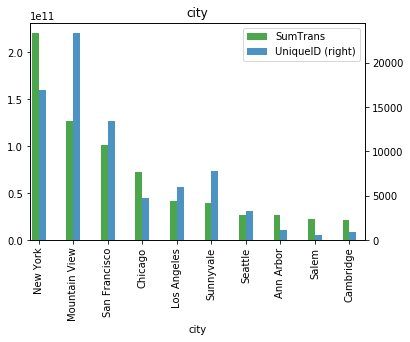

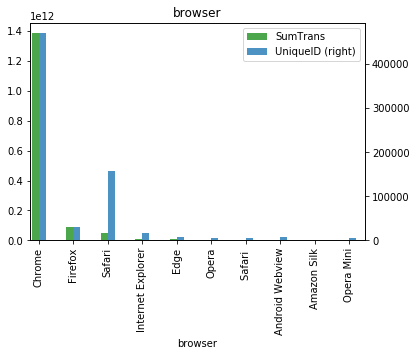

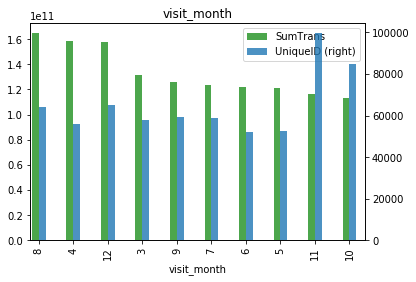

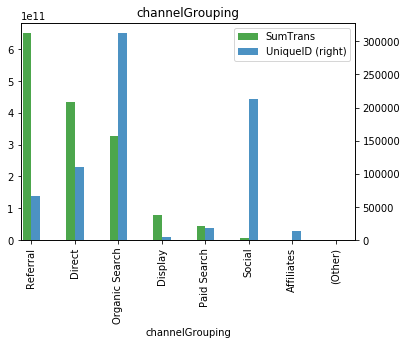

In [0]:
for col in cols:
    col_trans = customer.groupby(col)['transactionRevenue'].sum().reset_index()
    col_unique = customer.groupby(col)['fullVisitorId'].nunique().reset_index()
    col_merge = pd.merge(col_trans, col_unique, on = col)
    col_merge = col_merge.rename(columns = {'transactionRevenue': 'SumTrans', 'fullVisitorId': 'UniqueID'})
    col_merge = col_merge.sort_values(['SumTrans', 'UniqueID'], ascending = [0, 0]).head(10)
    
    ax = col_merge.plot(kind = 'bar', x = col, y = 'SumTrans', alpha=.7, color='g', position=1, width =.2)
    col_merge.plot(title = col, kind = 'bar', x = col, y = 'UniqueID', ax = ax, secondary_y=True, alpha=.8, position=0, width=.2)

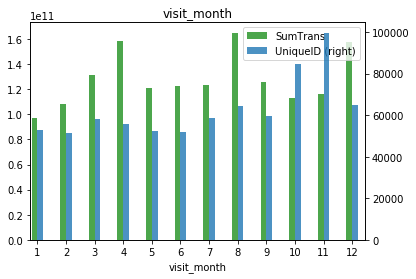

In [0]:
## reorder for visit_month
col = 'visit_month'
col_trans = customer.groupby(col)['transactionRevenue'].sum().reset_index()
col_unique = customer.groupby(col)['fullVisitorId'].nunique().reset_index()
col_merge = pd.merge(col_trans, col_unique, on = col)
col_merge = col_merge.rename(columns = {'transactionRevenue': 'SumTrans', 'fullVisitorId': 'UniqueID'})
    
ax = col_merge.plot(kind = 'bar', x = col, y = 'SumTrans', alpha=.7, color='g', position=1, width =.2)
col_merge.plot(title = col, kind = 'bar', x = col, rot=0, y = 'UniqueID', ax = ax, secondary_y=True, alpha=.8, position=0, width=.2)

### ***Data Finding: high sum & low count (green > blue): higher conversion rate***

# IV. RFM (Recency, Frequency, Monetary) Analysis

In [0]:
df = pd.read_csv("customer_dataset.csv")

In [0]:
df.head(1)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,...,pageviews,transactionRevenue,bounces,campaign,referralPath,source,keyword,adwordsClickInfo,medium,adContent
0,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",1131660440785968503,"{'continent': 'Asia', 'subContinent': 'Western...",1131660440785968503_1472830385,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472830385,...,1.0,NaN,1.0,(not set),NaN,google,(not provided),"{""criteriaParameters"": ""not available in demo ...",organic,NaN


In [0]:
df = df[['fullVisitorId', 'date', 'transactionRevenue']]
df = df[df['transactionRevenue'].isna()==False]
df['date'] = df['date'].apply(lambda x:str(x))
df['date'] = df['date'].apply(lambda x:datetime.strptime(x, '%Y%m%d'))
df.shape

(11515, 3)

In [0]:
df.head(5)

,fullVisitorId,date,transactionRevenue
752,6194193421514403509,2016-09-02,37860000.0
753,5327166854580374902,2016-09-02,306670000.0
799,8885051388942907862,2016-09-02,68030000.0
802,185467632009737931,2016-09-02,26250000.0
859,3244885836845029978,2016-09-02,574150000.0


In [0]:
df['date']

752      2016-09-02
753      2016-09-02
799      2016-09-02
802      2016-09-02
859      2016-09-02
            ...    
903302   2017-01-04
903305   2017-01-04
903314   2017-01-04
903315   2017-01-04
903317   2017-01-04
Name: date, Length: 11515, dtype: datetime64[ns]

In [0]:
type(df['date'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [0]:
df.describe()

,transactionRevenue
count,1.151500e+04
mean,1.337448e+08
std,4.482852e+08
min,1.000000e+04
25%,2.493000e+07
50%,4.945000e+07
75%,1.076550e+08
max,2.312950e+10


In [0]:
df.to_csv('customer_transaction.csv', index=False)

In [0]:
spark = SparkSession.builder.appName("RFM").getOrCreate()

In [0]:
data = spark.read.csv("customer_transaction.csv",header=True)

In [0]:
data = data.withColumn("datetime",data['date'].cast(DateType()))

In [0]:
data.show(5)

+-------------------+----------+------------------+----------+
|      fullVisitorId|      date|transactionRevenue|  datetime|
+-------------------+----------+------------------+----------+
|6194193421514403509|2016-09-02|        37860000.0|2016-09-02|
|5327166854580374902|2016-09-02|       306670000.0|2016-09-02|
|8885051388942907862|2016-09-02|        68030000.0|2016-09-02|
| 185467632009737931|2016-09-02|        26250000.0|2016-09-02|
|3244885836845029978|2016-09-02|       574150000.0|2016-09-02|
+-------------------+----------+------------------+----------+
only showing top 5 rows



In [0]:
data.count()

11515

#### **Create Recency**
#### **Get the last date of all transactions** 

In [0]:
max = data.agg({"date": "max"}).collect()[0][0]
data = data.withColumn('last_date', lit(max))
data.orderBy("fullVisitorId", "date").show(5)

+-------------------+----------+------------------+----------+----------+
|      fullVisitorId|      date|transactionRevenue|  datetime| last_date|
+-------------------+----------+------------------+----------+----------+
| 001905118576359487|2016-10-17|        17190000.0|2016-10-17|2017-08-01|
|0024932550342595467|2017-07-22|       126890000.0|2017-07-22|2017-08-01|
|0038111265827681261|2016-10-14|        19970000.0|2016-10-14|2017-08-01|
|0061519776091452595|2016-09-14|        13430000.0|2016-09-14|2017-08-01|
|0075449012662152580|2017-05-15|        38620000.0|2017-05-15|2017-08-01|
+-------------------+----------+------------------+----------+----------+
only showing top 5 rows



#### **Calculate recency, frequency, monetary of all users**

In [0]:
w = Window.partitionBy("fullVisitorId").orderBy("Date")
data = data.withColumn("recency", expr("datediff(last_date, Date)"))

group_data = data.groupBy("fullVisitorId")
df_rfm = group_data.agg({'recency':'min', 'fullVisitorId':'count', 'transactionRevenue':'sum'})
new_col_names = "visitorID", "monetary", "recency", "frequency"
for c,n in zip(df_rfm.columns,new_col_names):
    df_rfm=df_rfm.withColumnRenamed(c,n)
    
df_rfm.orderBy("visitorID").show(10)

+-------------------+---------+-------+---------+
|          visitorID| monetary|recency|frequency|
+-------------------+---------+-------+---------+
| 001905118576359487|  1.719E7|    288|        1|
|0024932550342595467| 1.2689E8|     10|        1|
|0038111265827681261|  1.997E7|    291|        1|
|0061519776091452595|  1.343E7|    321|        1|
|0075449012662152580|  3.862E7|     78|        1|
|0091725120799498455|  1.519E7|    141|        1|
|0092577710025173656| 4.9113E8|    288|        1|
|0110237584337011595|1.95155E9|    109|        1|
|0126612099954375841|1.00078E9|      0|        1|
|0143782636543876435|  7.598E7|     10|        1|
+-------------------+---------+-------+---------+
only showing top 10 rows



In [0]:
df_rfm.count()

10004

#### **Plot RFM distributions**
#### **Convert the spark df to pandas df for visualization**

In [0]:
rfm_pandas = df_rfm.toPandas()

In [0]:
rfm_pandas.head(2)

,visitorID,monetary,recency,frequency
0,5610631581931690167,67950000.0,49,1
1,9972043774359472649,671220000.0,335,1


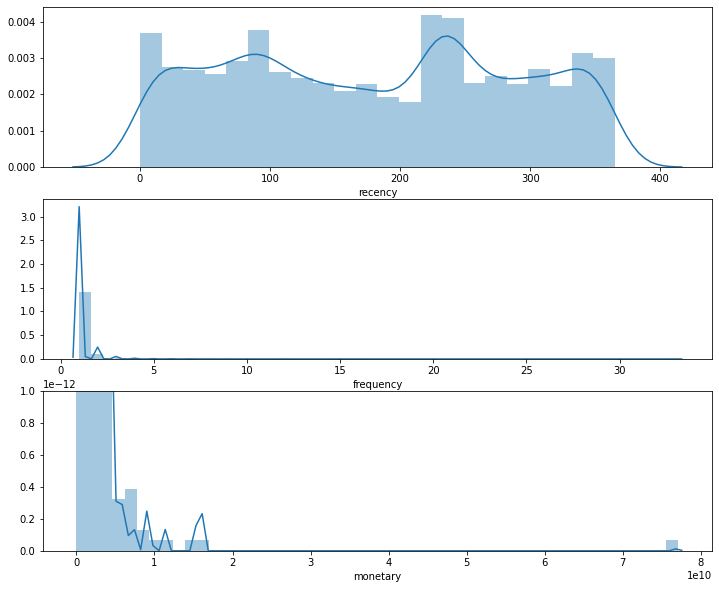

In [0]:
plt.figure(figsize=(12,10))
# Plot distribution of Recency
plt.subplot(3,1,1)
sns.distplot(rfm_pandas['recency'])
# Plot distribution of Frequency
plt.subplot(3,1,2)
sns.distplot(rfm_pandas['frequency'])
# Plot distribution of Recency
plt.subplot(3,1,3)
sns.distplot(rfm_pandas['monetary'])

#### **Create R, F, M quantile groups**

In [0]:
df_rfm = df_rfm.withColumn(
    'f',
    F.when(F.col('frequency') > 1, 2)\
    .otherwise(1)
)

In [0]:
df_rfm.orderBy("visitorID").show(5)

+-------------------+--------+-------+---------+---+
|          visitorID|monetary|recency|frequency|  f|
+-------------------+--------+-------+---------+---+
| 001905118576359487| 1.719E7|    288|        1|  1|
|0024932550342595467|1.2689E8|     10|        1|  1|
|0038111265827681261| 1.997E7|    291|        1|  1|
|0061519776091452595| 1.343E7|    321|        1|  1|
|0075449012662152580| 3.862E7|     78|        1|  1|
+-------------------+--------+-------+---------+---+
only showing top 5 rows



In [0]:
quantiles = df_rfm.approxQuantile("recency", [0.25, 0.5, 0.75], 0)
df_rfm = df_rfm.withColumn(
    'r',
    F.when(F.col('recency') <= quantiles[0], 4)\
    .when(F.col('recency') <= quantiles[1], 3)\
    .when(F.col('recency') <= quantiles[2], 2)\
    .otherwise(1)
)
df_rfm.orderBy("visitorID").show(5)

+-------------------+--------+-------+---------+---+---+
|          visitorID|monetary|recency|frequency|  f|  r|
+-------------------+--------+-------+---------+---+---+
| 001905118576359487| 1.719E7|    288|        1|  1|  1|
|0024932550342595467|1.2689E8|     10|        1|  1|  4|
|0038111265827681261| 1.997E7|    291|        1|  1|  1|
|0061519776091452595| 1.343E7|    321|        1|  1|  1|
|0075449012662152580| 3.862E7|     78|        1|  1|  4|
+-------------------+--------+-------+---------+---+---+
only showing top 5 rows



In [0]:
quantiles = df_rfm.approxQuantile("monetary", [0.25, 0.5, 0.75], 0)

df_rfm = df_rfm.withColumn(
    'm',
    F.when(F.col('monetary') <= quantiles[0], 1)\
    .when(F.col('monetary') <= quantiles[1], 2)\
    .when(F.col('monetary') <= quantiles[2], 3)\
    .otherwise(4)
)
df_rfm.orderBy("visitorID").show(5)

+-------------------+--------+-------+---------+---+---+---+
|          visitorID|monetary|recency|frequency|  f|  r|  m|
+-------------------+--------+-------+---------+---+---+---+
| 001905118576359487| 1.719E7|    288|        1|  1|  1|  1|
|0024932550342595467|1.2689E8|     10|        1|  1|  4|  4|
|0038111265827681261| 1.997E7|    291|        1|  1|  1|  1|
|0061519776091452595| 1.343E7|    321|        1|  1|  1|  1|
|0075449012662152580| 3.862E7|     78|        1|  1|  4|  2|
+-------------------+--------+-------+---------+---+---+---+
only showing top 5 rows



#### **Create RFM Segment**

In [0]:
df_rfm = df_rfm.withColumn('RFM_Segment', 
    F.concat(F.col('r'), F.col('f'), F.col('m')))
df_rfm.orderBy('visitorID').show(5)

+-------------------+--------+-------+---------+---+---+---+-----------+
|          visitorID|monetary|recency|frequency|  f|  r|  m|RFM_Segment|
+-------------------+--------+-------+---------+---+---+---+-----------+
| 001905118576359487| 1.719E7|    288|        1|  1|  1|  1|        111|
|0024932550342595467|1.2689E8|     10|        1|  1|  4|  4|        414|
|0038111265827681261| 1.997E7|    291|        1|  1|  1|  1|        111|
|0061519776091452595| 1.343E7|    321|        1|  1|  1|  1|        111|
|0075449012662152580| 3.862E7|     78|        1|  1|  4|  2|        412|
+-------------------+--------+-------+---------+---+---+---+-----------+
only showing top 5 rows



### How many unique RFM segments do we have?

In [0]:
df_rfm.select(F.countDistinct("RFM_Segment")).show()

+---------------------------+
|count(DISTINCT RFM_Segment)|
+---------------------------+
|                         32|
+---------------------------+



#### **Segment customers based on their RFM_segment**

In [0]:
def segment_customers(r, f, m):
  # Core - Your Best Customers
    if r == 4 and f == 2 and m == 4:
        return "Best Customers"
    # Promising - Faithful customers
    if f == 2 and m < 3:
        return "Promising customers"
    # Rookies - Your Newest Customers
    if r == 4 and f == 1:
        return "Newest Customers"
    # At risk customers
    if (r == 2 or r == 3)  and (m == 2 or m == 3):
        return "At Risk Customers"
    # Loyal - Your Most Loyal Customers
    if f == 2:
        return "Loyal Customers"
    # Whales - Your ​Highest Paying Customers
    if m == 4:
        return "Highest Paying Customers"
    # Slipping - ​Once Loyal, Now Gone
    if r == 1 and f == 1:
        return "Churned Customers"
    else:
        return "Other"

spark.udf.register("segmentWithPython", segment_customers)
segment_udf = udf(segment_customers, StringType())

In [0]:
df_rfm = df_rfm.withColumn('customer_group', segment_udf('r','f','m'))
df_rfm.show(5)

+-------------------+--------+-------+---------+---+---+---+-----------+--------------------+
|          visitorID|monetary|recency|frequency|  f|  r|  m|RFM_Segment|      customer_group|
+-------------------+--------+-------+---------+---+---+---+-----------+--------------------+
|5610631581931690167| 6.795E7|     49|        1|  1|  4|  3|        413|    Newest Customers|
|9972043774359472649|6.7122E8|    335|        1|  1|  1|  4|        114|Highest Paying Cu...|
|8706126538675944851| 3.352E8|    245|        1|  1|  2|  4|        214|Highest Paying Cu...|
|4100254762425335988| 7.427E7|    144|        2|  2|  3|  3|        323|   At Risk Customers|
|4625952167494304032| 3.359E7|     95|        1|  1|  3|  2|        312|   At Risk Customers|
+-------------------+--------+-------+---------+---+---+---+-----------+--------------------+
only showing top 5 rows



In [0]:
df_count_group = df_rfm.groupBy('customer_group').count()
df_count_group.show(8)

+--------------------+-----+
|      customer_group|count|
+--------------------+-----+
| Promising customers|   87|
|   At Risk Customers| 2485|
|Highest Paying Cu...| 1439|
|               Other| 1281|
|     Loyal Customers|  578|
|      Best Customers|  186|
|   Churned Customers| 1731|
|    Newest Customers| 2217|
+--------------------+-----+

